In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
 
from random import choice,shuffle
from scipy import stats as st
from tensorflow.keras.optimizers import RMSprop
from collections import deque

In [39]:
def gather_data(num_samples):
    global rock, paper, scissor, nothing
    cap = cv2.VideoCapture(0)
    trigger = False
    counter = 0
    box_size = 234
    width = int(cap.get(3))
    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        if not ret:
            break
        if counter == num_samples:
            trigger = not trigger
            counter = 0
        cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
        cv2.namedWindow("Collecting images", cv2.WINDOW_NORMAL)
        if trigger:
            roi = frame[5: box_size-5 , width-box_size + 5: width -5]
            eval(class_name).append([roi, class_name])
            counter += 1
            text = "Collected Samples of {}: {}".format(class_name, counter)
        else:
            text = "Press 'r' to collect rock samples, 'p' for paper, 's' for scissor and 'n' for nothing"
        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.imshow("Collecting images", frame)
        k = cv2.waitKey(1)
        if k == ord('r'):
            trigger = not trigger
            class_name = 'rock'
            rock = []
        if k == ord('p'):
            trigger = not trigger
            class_name = 'paper'
            paper = []
        if k == ord('s'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []
        if k == ord('n'):
            trigger = not trigger
            class_name = 'nothing'
            nothing = []
        if k == ord('f'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [40]:
no_of_samples = 300
gather_data(no_of_samples)

In [41]:
labels = [tupl[1] for tupl in rock] + [tupl[1] for tupl in paper] + [tupl[1] for tupl in scissor] +[tupl[1] for tupl in nothing]
 
images = [tupl[0] for tupl in rock] + [tupl[0] for tupl in paper] + [tupl[0] for tupl in scissor] +[tupl[0] for tupl in nothing]
 
images = np.array(images, dtype="float") / 255.0
 
print('Total images: {} , Total Labels: {}'.format(len(labels), len(images)))
 
encoder = LabelEncoder()
 
Int_labels = encoder.fit_transform(labels)
 
one_hot_labels = to_categorical(Int_labels, 4)
 
(trainX, testX, trainY, testY) = train_test_split(images, one_hot_labels, test_size=0.25, random_state=50)
 
images = []

Total images: 1200 , Total Labels: 1200


In [42]:
image_size = 224
 
N_mobile = tf.keras.applications.NASNetMobile( input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
 
N_mobile.trainable = False
     
x = N_mobile.output
 
x = GlobalAveragePooling2D()(x)
 
x = Dense(712, activation='relu')(x) 
 
x = Dropout(0.40)(x)
 
preds = Dense(4,activation='softmax')(x) 
 
model = Model(inputs=N_mobile.input, outputs=preds)
 
print ("Number of Layers in Model: {}".format(len(model.layers[:])))

Number of Layers in Model: 773


In [48]:
augment = ImageDataGenerator( 
     
        rotation_range=30,
        zoom_range=0.25,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        horizontal_flip=False,
        fill_mode="nearest"
)

In [49]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [50]:
epochs = 10
batchsize = 64
history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
steps_per_epoch= len(trainX) // batchsize, epochs=epochs)

Epoch 1/10


c:\Users\ADMIN\Downloads\Python_\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.3983 - loss: 1.3445 - val_accuracy: 0.8133 - val_loss: 0.6029
Epoch 2/10
 1/14 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6719 - loss: 0.8371

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 477ms/step - accuracy: 0.6719 - loss: 0.8371 - val_accuracy: 0.7900 - val_loss: 0.5775
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7657 - loss: 0.6681 - val_accuracy: 0.9533 - val_loss: 0.3410
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - accuracy: 0.8750 - loss: 0.4049 - val_accuracy: 0.9567 - val_loss: 0.3312
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8691 - loss: 0.4457 - val_accuracy: 0.9267 - val_loss: 0.2611
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - accuracy: 0.9531 - loss: 0.3199 - val_accuracy: 0.9367 - val_loss: 0.2546
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9040 - loss: 0.3348 - val_accuracy: 0.9767 - val_loss: 0.1876
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step - accuracy: 1.0000 - loss: 0.0644 - val_accuracy: 0.9633 - val_loss: 0.1897
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9244 - loss: 0.2785 - val_accuracy: 0.9833 - val_loss: 0.

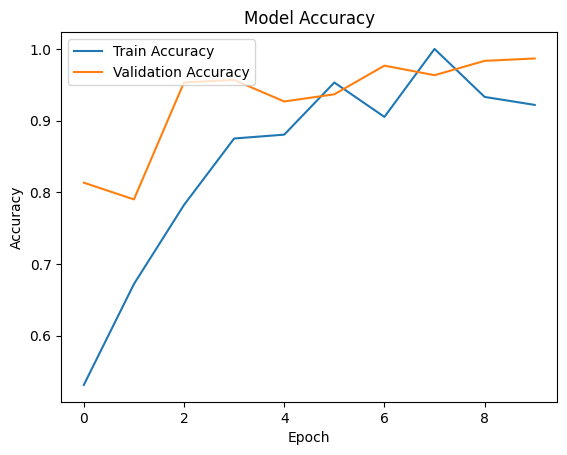

In [51]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

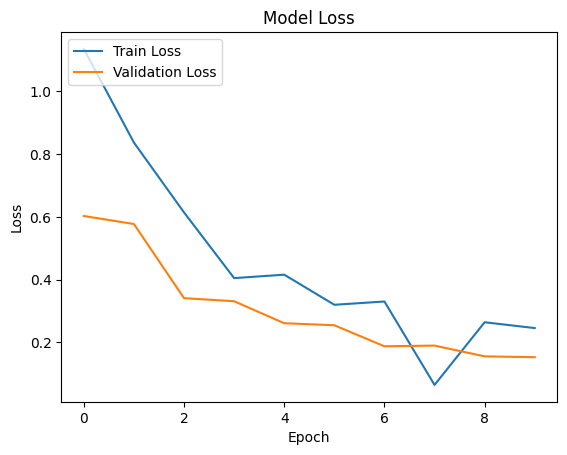

In [52]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [53]:
label_names = ['nothing', 'paper', 'rock', 'scissor']
 
cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))
 
while True:
     
    ret, frame = cap.read()
    if not ret:
        break
         
    frame = cv2.flip(frame, 1)
            
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
         
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)
 
    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
     
    roi = np.array([roi]).astype('float64') / 255.0
  
    pred = model.predict(roi)
     
    target_index = np.argmax(pred[0])
 
    prob = np.max(pred[0])
 
    cv2.putText(frame, "prediction: {} {:.2f}%".format(label_names[np.argmax(pred[0])], prob*100 ),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
     
    cv2.imshow("Rock Paper Scissors", frame)
     
    
    k = cv2.waitKey(1)
    if k == ord('f'):
        break
 
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

In [24]:
def findout_winner(user_move, Computer_move):
     
    if user_move == Computer_move:
        return "Tie"   
     
    elif user_move == "rock" and Computer_move == "scissor":
        return "User"
     
    elif user_move == "rock" and Computer_move == "paper":
        return "Computer"
     
    elif user_move == "scissor" and Computer_move == "rock":
        return "Computer"
     
    elif user_move == "scissor" and Computer_move == "paper":
        return "User"
     
    elif user_move == "paper" and Computer_move == "rock":
        return "User"
     
    elif user_move == "paper" and Computer_move == "scissor":
        return "Computer"

In [25]:
user_move = 'paper'
computer_move = choice(['rock', 'paper', 'scissor'])
 
winner = findout_winner(user_move, computer_move)
 
print("User Selected '{}' and computer selected '{}' , winner is: '{}' ".format(user_move, computer_move, winner))


User Selected 'paper' and computer selected 'paper' , winner is: 'Tie' 


In [27]:
def show_winner(user_socre, computer_score):    
     
    if user_score > computer_score:
        img = cv2.imread("images/youwin.jpg")
         
    elif user_score < computer_score:
        img = cv2.imread("images/comwins.jpg")
         
    else:
        img = cv2.imread("images/draw.jpg")
         
    cv2.putText(img, "Press 'ENTER' to play again, else exit",
                (150, 530), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
     
    cv2.imshow("Rock Paper Scissors", img)
     
    # If enter is pressed.
    k = cv2.waitKey(0)
    
    if k == 13:
       return True
 
    else:
        return False

In [28]:
def display_computer_move(computer_move_name, frame):
     
    icon = cv2.imread( "images/{}.png".format(computer_move_name), 1)
    icon = cv2.resize(icon, (224,224))
    roi = frame[0:224, 0:224]
    mask = icon[:,:,-1] 
    mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]
    icon_bgr = icon[:,:,:3] 
    img1_bg = cv2.bitwise_and(roi, roi, mask = cv2.bitwise_not(mask))
 
    img2_fg = cv2.bitwise_and(icon_bgr, icon_bgr, mask = mask)
 
    combined = cv2.add(img1_bg, img2_fg)
 
    frame[0:224, 0:224] = combined
 
    return frame

In [38]:
import random

label_names = ['nothing', 'paper', 'rock', 'scissor']

cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))

def determine_winner(user_move, computer_move):
    if user_move == computer_move:
        return "Draw"
    elif (user_move == 'rock' and computer_move == 'scissor') or \
         (user_move == 'scissor' and computer_move == 'paper') or \
         (user_move == 'paper' and computer_move == 'rock'):
        return "You win"
    else:
        return "You lose"

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)

    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)

    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    
    roi = np.array([roi]).astype('float64') / 255.0

    pred = model.predict(roi)
  
    target_index = np.argmax(pred[0])

 
    prob = np.max(pred[0])

    user_move = label_names[target_index]

  
    computer_move = random.choice(['paper', 'rock', 'scissor'])

    if user_move != 'nothing':
        result = determine_winner(user_move, computer_move)
    else:
        result = "Waiting..."

 
    cv2.putText(frame, "You: {} {:.2f}%".format(user_move, prob * 100),
            (10, 40), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, "Player 2: {}".format(computer_move),
                (10, 80), cv2.FONT_HERSHEY_DUPLEX, 0.90, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, result,
                (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Rock Paper Scissors", frame)
    
    k = cv2.waitKey(1)
    if k == ord('f'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━